In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
sys.path.insert(0, "/so/home/jsugiyama/git/sotodlib/")
import sotodlib
from sotodlib.tod_ops import fft_ops, detrend_tod
from sotodlib import core
from sotodlib import hwp
from sotodlib.io import load_smurf as ls
from sotodlib.io.load_smurf import Observations, Files, TuneSets, Tunes
from sotodlib.io import g3tsmurf_utils
import datetime

In [2]:
start = datetime.datetime.now()
ctx_file = '/so/metadata/satp3/contexts/use_this.yaml'
ctx = core.Context(ctx_file)
obs_id = 'obs_1709601492_satp3_1111111'
ws = 'ws0'
bandpass = 'f150'
meta = ctx.get_meta(obs_id, dets={'wafer_slot': ws, 'wafer.bandpass': bandpass})
aman = ctx.get_obs(meta)
for idet in range(aman.dets.count) : 
    aman.signal[idet] *= aman.det_cal.phase_to_pW[idet]
alive = np.where(np.any(np.isnan(aman.signal), axis=1)==False)
aman.restrict('dets', aman.dets.vals[alive])
detrend_tod(aman)
signal=aman.signal
freqs, pxx = fft_ops.calc_psd(
            aman, signal=signal, timestamps=aman.timestamps, max_samples=2**20, merge=True, nperseg=len(aman.timestamps)
        )
stop = datetime.datetime.now()
print(stop - start)

0:00:44.833535


# New features

* PSD mask
    * Masking HWPSS or vibration signals makes the fitting stable
* PSD binning
    * Fitting becomes about 25 times faster than without binning
    * Knee frequency and white noise level are unbiased
    * The standard errors of the fit parameters become smaller
* Other changes in the fitting functions
    * Fitting parameters can be reduced (white noise or alpha can be fixed)
    * Minimum frequency for the fit can be decrared
    * IndexError Exception is added to the Hessian calculation. IndexError occurs when the 1/f fit fails in the case where, for example, the signal is nan.

# "calc_psd_mask"

``calc_psd_mask`` returns Ranges array to mask hwpss or single peak in the given PSD.\
If mode == "replace", it will return new mask in aman.PSD_mask.\
If mode == "add", new mask range will be added to the existing aman.PSD_mask.
You can obtain masked PSD like:\
"""\
mask = ~aman.PSD_mask.mask()\
f = f[mask]\
pxx = pxx[:, mask]\
"""

0:00:00.139487


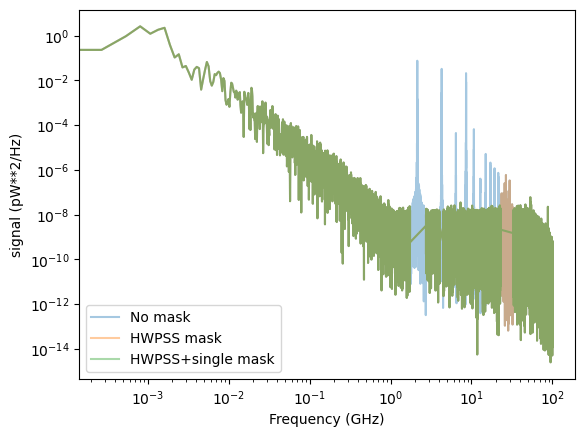

In [3]:
start = datetime.datetime.now()
plt.figure()
plt.loglog(aman.freqs, aman.Pxx[0], alpha=0.4, label="No mask")
# create hwpss mask
fft_ops.calc_psd_mask(aman, mask_hwpss=True, hwpss_width=((-0.4, 0.6),(-0.2, 0.2)), merge=True)
mask = ~aman.psd_mask.mask()
plt.loglog(aman.freqs[mask], aman.Pxx[0][mask], alpha=0.4, label="HWPSS mask")

# add single peak mask
fft_ops.calc_psd_mask(aman, psd_mask=aman.psd_mask.mask(),mask_peak=True, peak_freq=28, peak_width=(-5, +5), merge=True)
mask = ~aman.psd_mask.mask()
plt.loglog(aman.freqs[mask], aman.Pxx[0][mask], alpha=0.4, label="HWPSS+single mask")
plt.xlabel('Frequency (GHz)')
plt.ylabel('signal (pW**2/Hz)')
plt.legend()
stop = datetime.datetime.now()
print(stop - start)

# "fit_noise_model"

New feature of fit_noise_model is that
* Fit PSD with masks if ``mask``==True and PSD_mask in aman,
* Parameters of white noise or alpha can be fixed to the initially estimated value. For example, we experimentally know that fixing alpha is good for fitting demodulated signals.
* ``f_min`` has been added to limit the minimum frequency to fit.

In [4]:
start = datetime.datetime.now()
noise_fit_stats_fixed_wn = fft_ops.fit_noise_model(aman, 
                                          f=aman.freqs, 
                                          pxx=aman.Pxx, 
                                          lowf=1, 
                                          f_min=0.001, 
                                          f_max=20, 
                                          fwhite=(3, 20), 
                                          mask=True, 
                                          fixed_parameter={"wn":2E-9})
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)


0:01:52.711395


In [5]:
start = datetime.datetime.now()
noise_fit_stats_fixed_alpha = fft_ops.fit_noise_model(aman, 
                                          f=aman.freqs, 
                                          pxx=aman.Pxx, 
                                          lowf=1, 
                                          f_min=0.001, 
                                          f_max=20, 
                                          fwhite=(3, 20), 
                                          mask=True, 
                                          fixed_parameter={"alpha":3.4})
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.p

0:02:02.761576


In [6]:
start = datetime.datetime.now()
noise_fit_stats_all_params = fft_ops.fit_noise_model(aman, 
                                          f=aman.freqs, 
                                          pxx=aman.Pxx, 
                                          lowf=1, 
                                          f_min=0.001, 
                                          f_max=20, 
                                          fwhite=(3, 20), 
                                          mask=True)
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)


0:04:14.565212


In [7]:
noise_fit_stats_fixed_wn.fit

array([[1.17094340e+00, 2.00000000e-09, 3.28081038e+00],
       [1.15688262e+00, 2.00000000e-09, 3.29040022e+00],
       [1.16994709e+00, 2.00000000e-09, 3.31446268e+00],
       ...,
       [1.09956407e+00, 2.00000000e-09, 3.38281480e+00],
       [1.20806557e+00, 2.00000000e-09, 3.30624163e+00],
       [1.29905619e+00, 2.00000000e-09, 3.20806127e+00]])

In [8]:
noise_fit_stats_fixed_alpha.fit

array([[1.05796465e+00, 2.34685167e-09, 3.40000000e+00],
       [1.06630072e+00, 2.25400590e-09, 3.40000000e+00],
       [1.06829360e+00, 2.35432815e-09, 3.40000000e+00],
       ...,
       [1.03987434e+00, 2.28379744e-09, 3.40000000e+00],
       [1.07449828e+00, 2.50817179e-09, 3.40000000e+00],
       [1.07608622e+00, 2.70525016e-09, 3.40000000e+00]])

In [9]:
noise_fit_stats_all_params.fit

array([[1.06868204e+00, 2.34525013e-09, 3.36870993e+00],
       [1.08285225e+00, 2.25167783e-09, 3.35218570e+00],
       [1.06593998e+00, 2.35473238e-09, 3.40678256e+00],
       ...,
       [1.02119352e+00, 2.28643190e-09, 3.45534547e+00],
       [1.06490260e+00, 2.50959164e-09, 3.42825248e+00],
       [1.07476207e+00, 2.70538544e-09, 3.40381974e+00]])

Text(0.5, 0, 'fknee (Hz)')

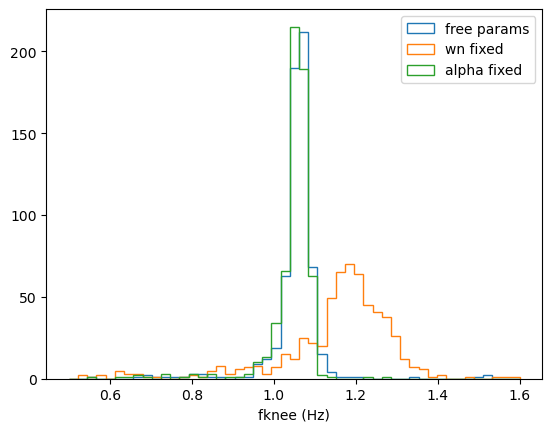

In [15]:
plt.figure()
plt.hist(noise_fit_stats_all_params.fit.T[0], bins=np.linspace(0.5, 1.6, 50), histtype=u'step', label="free params")
plt.hist(noise_fit_stats_fixed_wn.fit.T[0], bins=np.linspace(0.5, 1.6, 50), histtype=u'step', label="wn fixed")
plt.hist(noise_fit_stats_fixed_alpha.fit.T[0], bins=np.linspace(0.5, 1.6, 50), histtype=u'step', label="alpha fixed")
plt.legend()
plt.xlabel("fknee (Hz)")

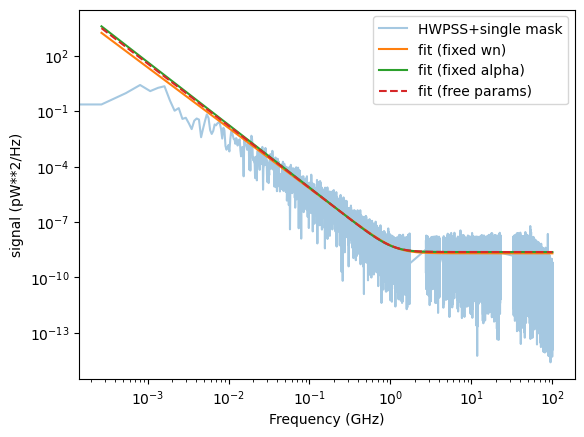

In [16]:
plt.figure()
plt.loglog(aman.freqs[mask], aman.Pxx[0][mask], alpha=0.4, label="HWPSS+single mask")

noise_fit_stats = noise_fit_stats_fixed_wn
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]), label="fit (fixed wn)")

noise_fit_stats = noise_fit_stats_fixed_alpha
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]), label="fit (fixed alpha)")

noise_fit_stats = noise_fit_stats_all_params
plt.loglog(aman.freqs, fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0]),"--",  label="fit (free params)")

plt.xlabel('Frequency (GHz)')
plt.ylabel('signal (pW**2/Hz)')
plt.legend()

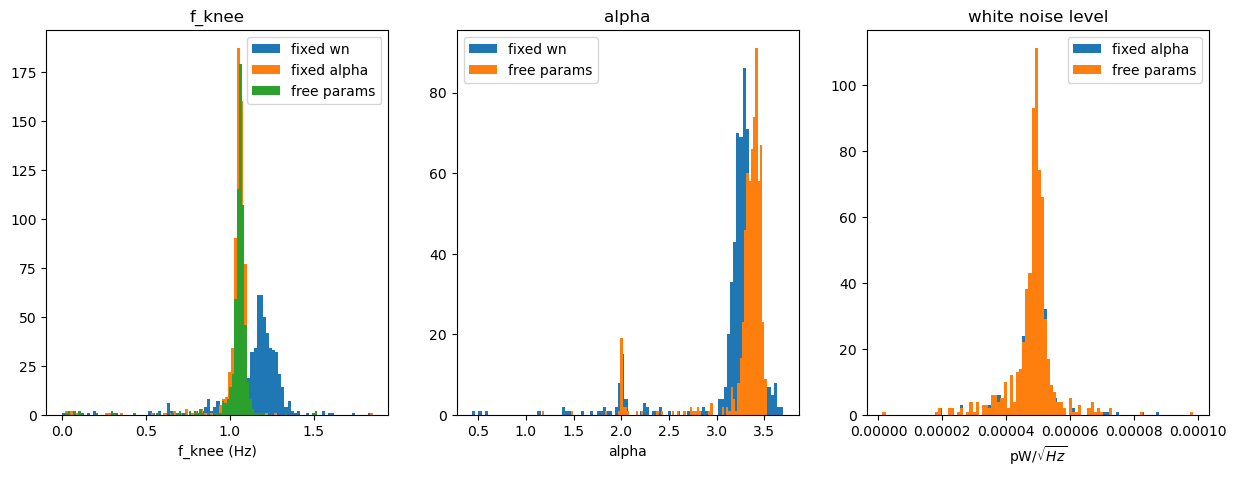

In [17]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee")
noise_fit_stats = noise_fit_stats_fixed_wn
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="fixed wn")

noise_fit_stats = noise_fit_stats_fixed_alpha
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="fixed alpha")

noise_fit_stats = noise_fit_stats_all_params
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="free params")
ax1.set_xlabel('f_knee (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha")
noise_fit_stats = noise_fit_stats_fixed_wn
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="fixed wn")

noise_fit_stats = noise_fit_stats_all_params
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="free params")
ax2.set_xlabel('alpha')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise level")

noise_fit_stats = noise_fit_stats_fixed_alpha
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="fixed alpha")

noise_fit_stats = noise_fit_stats_all_params
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="free params")
ax3.set_xlabel('pW/$\sqrt{Hz}$')
ax3.legend()

# "calc_binned_psd"

``calc_binned_psd`` returns the binned PSD. This function is incorporated to ``fit_binned_noise_model``.\
The parameters ``unbinned_mode`` and ``base`` changes the number of first un-binned modes and binning width, respectively.\
If the number of data points in a bin is less than ``limit_N``, that bin is handled with
chi2 distribution and its error is \<psd>. Otherwise the central limit theorem
is applied to the bin and the error is estimated as  std(psd)/sqrt(len(psd)).

In [22]:
start = datetime.datetime.now()
mask = ~aman.psd_mask.mask()
f = aman.freqs[mask]
pxx = aman.Pxx[:, mask]
f_binned, pxx_binned, bin_size = fft_ops.calc_binned_psd(aman, f=f, pxx=pxx, unbinned_mode=3, base=1.2, merge=False)
stop = datetime.datetime.now()
print(stop - start)

0:00:01.495386


In [32]:
len(pxx_binned)

661

In [18]:
aman.Pxx.shape

(661, 370684)

In [17]:
pxx_binned.shape

(661, 69)

(0.0001, 50)

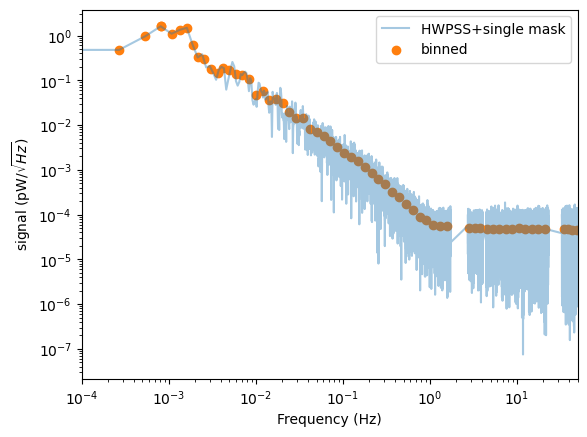

In [24]:
plt.loglog(aman.freqs[mask], np.sqrt(aman.Pxx[0][mask]), alpha=0.4, label="HWPSS+single mask")
plt.scatter(f_binned, np.sqrt(pxx_binned[0]), c='tab:orange', label="binned")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('signal (pW/$\sqrt{Hz}$)')
plt.xlim(1E-4, 50)

## "fit_binned_noise_model"
This function calculates binned PSD and then starts fitting when PSD is handed.\
The calculation time cost becomes much smaller.

In [23]:
fwhite=(3, 20)
p = pxx_binned[1]
f = f_binned
print(p)
print(f)
wnest = np.median(p[((f > fwhite[0]) & (f < fwhite[1]))])*1.5

[8.14088210e-02 2.28070468e-01 8.88465464e-01 2.47808433e+00
 2.47808433e+00 1.16312361e+00 1.77316606e+00 2.14831758e+00
 3.59296709e-01 9.54714492e-02 9.14030075e-02 3.65557969e-02
 2.08907053e-02 3.98094915e-02 2.86360160e-02 1.87569391e-02
 1.76434778e-02 1.17468778e-02 2.26486474e-03 3.59308370e-03
 1.33922289e-03 1.55595236e-03 8.59019172e-04 3.65239568e-04
 1.92224106e-04 2.06169891e-04 5.83372312e-05 4.89313170e-05
 3.08396775e-05 1.72491546e-05 1.20703035e-05 4.87735588e-06
 3.79398625e-06 2.60634988e-06 1.18623609e-06 6.17150931e-07
 3.48346219e-07 2.02906165e-07 1.14217585e-07 5.74623336e-08
 3.07446975e-08 1.57545994e-08 7.88529597e-09 4.65413130e-09
 3.62504093e-09 2.98526515e-09 2.99071368e-09 2.56142352e-09
 2.41889242e-09 2.40575249e-09 2.27845320e-09 2.32052044e-09
 2.18938911e-09 2.27976060e-09 2.21616725e-09 2.25077468e-09
 2.33879693e-09 2.22930163e-09 2.20868057e-09 2.25302288e-09
 2.24789054e-09 2.04295514e-09 1.95012895e-09 1.79861714e-09
 1.48506052e-09 8.579100

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [24]:
fwhite=(3, 20)
p = aman.Pxx[:, mask][1]
f = aman.freqs[mask]
print(p)
print(f)
wnest = np.median(p[((f > fwhite[0]) & (f < fwhite[1]))])*1.5

[8.1408821e-02 2.2807047e-01 8.8846546e-01 ... 2.9207886e-10 1.8257970e-10
 5.5733786e-11]
[0.00000000e+00 2.69778611e-04 5.39557221e-04 ... 1.00001805e+02
 1.00002075e+02 1.00002345e+02]


In [20]:
start = datetime.datetime.now()
noise_fit_stats_bin = fft_ops.fit_noise_model(aman, 
                                             f=aman.freqs, 
                                             pxx=aman.Pxx, 
                                             lowf=1, 
                                             f_min=0.001, 
                                             f_max=20, 
                                             fwhite=(3, 20), 
                                             mask=True, 
                                             binning=True,
                                             unbinned_mode=1, base=1.2)
stop = datetime.datetime.now()
print(stop - start)

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:371: RuntimeWarning: invalid value encountered in log
  output = np.sum((np.log(model) + y / model)*bin_size)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:371: RuntimeWarning: invalid value encountered in log
  output = np.sum((np.log(model) + y / model)*bin_size)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:371: RuntimeWarning: invalid value encountered in log
  output = np.sum((np.log(model) + y / model)*bin_size)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:371: RuntimeWarning: invalid value encountered in log
  output = np.sum((np.log(model) + y / model)*bin_size)
/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: invalid value encountered in power
  return wn * (1 + (fknee / f) ** alpha)
/so/ho

0:00:07.964665


### comparison of fit results between binned and not binned PSD

/so/home/jsugiyama/git/sotodlib/sotodlib/tod_ops/fft_ops.py:366: RuntimeWarning: divide by zero encountered in divide
  return wn * (1 + (fknee / f) ** alpha)


(0.0001, 50)

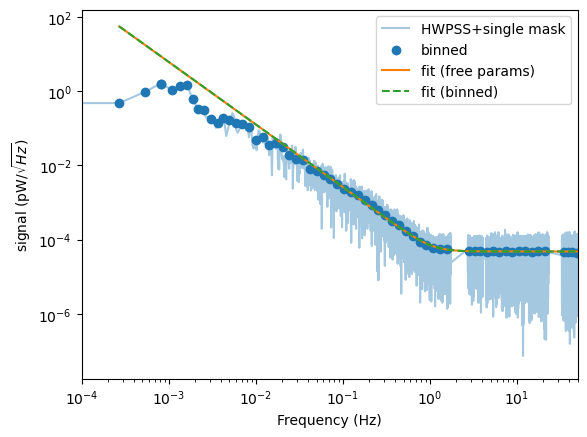

In [23]:
plt.loglog(aman.freqs[mask], np.sqrt(aman.Pxx[0][mask]), alpha=0.4, label="HWPSS+single mask", zorder=0)
plt.scatter(f_binned, np.sqrt(pxx_binned[0]), label="binned", zorder=1)
noise_fit_stats = noise_fit_stats_all_params
plt.loglog(aman.freqs, np.sqrt(fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0])),  label="fit (free params)")
noise_fit_stats = noise_fit_stats_bin
plt.loglog(aman.freqs, np.sqrt(fft_ops.noise_model(aman.freqs, noise_fit_stats.fit[0])), label="fit (binned)", ls="--")
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('signal (pW/$\sqrt{Hz}$)')
plt.xlim(1E-4, 50)

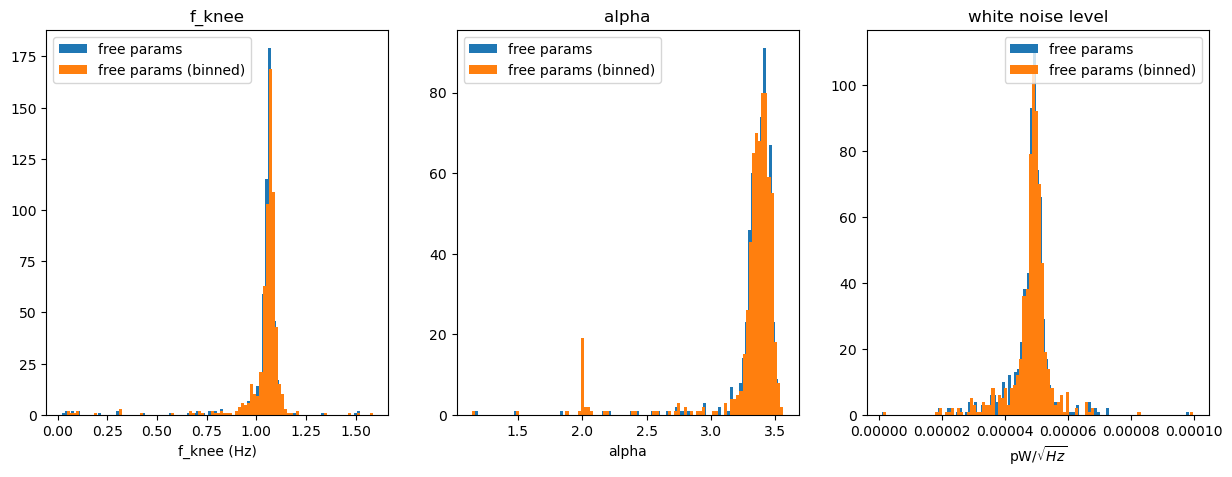

In [25]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee")
noise_fit_stats = noise_fit_stats_all_params
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
f_knee = noise_fit_stats.fit.T[0]
ax1.hist(f_knee[((f_knee>0)&(f_knee<2))], bins=100, label="free params (binned)")

ax1.set_xlabel('f_knee (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha")
noise_fit_stats = noise_fit_stats_all_params
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="free params")

noise_fit_stats = noise_fit_stats_bin
alpha = noise_fit_stats.fit.T[2]
ax2.hist(alpha[((alpha>0)&(alpha<4))], bins=100, label="free params (binned)")

ax2.set_xlabel('alpha')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise level")
noise_fit_stats = noise_fit_stats_all_params
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
wn = noise_fit_stats.fit.T[1]
ax3.hist(np.sqrt(wn)[np.sqrt(wn)<0.0001], bins=100, label="free params (binned)")
ax3.set_xlabel('pW/$\sqrt{Hz}$')
ax3.legend()

### comparison of fit parameters std errors between binned and not binned

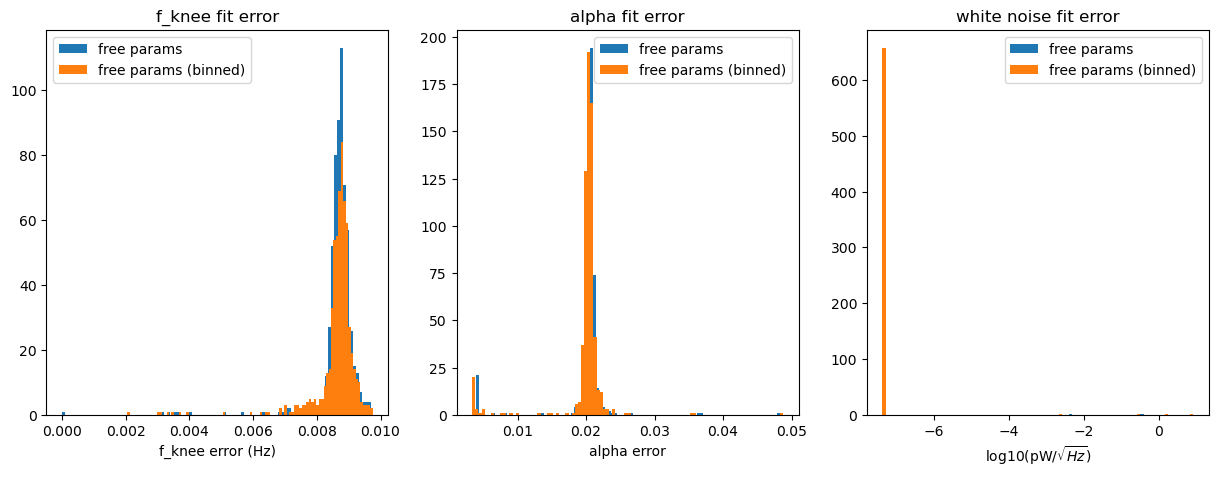

In [26]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("f_knee fit error")
f_knee = []
alpha = []
wn = []
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    f_knee.append(np.sqrt(noise_fit_stats.cov[i][0][0]))
f_knee=np.array(f_knee)
ax1.hist(f_knee[((f_knee>0)&(f_knee<0.01))], bins=100, label="free params")
noise_fit_stats = noise_fit_stats_bin
f_knee = []
for i in range(aman.dets.count):
    f_knee.append(np.sqrt(noise_fit_stats.cov[i][0][0]))
f_knee=np.array(f_knee)
ax1.hist(f_knee[((f_knee>0)&(f_knee<0.01))], bins=100, label="free params (binned)")

ax1.set_xlabel('f_knee error (Hz)')
ax1.legend()

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("alpha fit error")
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    alpha.append(np.sqrt(noise_fit_stats.cov[i][2][2]))
alpha=np.array(alpha)
ax2.hist(alpha[((alpha>0)&(alpha<0.05))], bins=100, label="free params")

noise_fit_stats = noise_fit_stats_bin
alpha = []
for i in range(aman.dets.count):
    alpha.append(np.sqrt(noise_fit_stats.cov[i][2][2]))
alpha=np.array(alpha)
ax2.hist(alpha[((alpha>0)&(alpha<0.05))], bins=100, label="free params (binned)")

ax2.set_xlabel('alpha error')
ax2.legend()

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("white noise fit error")
noise_fit_stats = noise_fit_stats_all_params
for i in range(aman.dets.count):
    wn.append(np.sqrt(noise_fit_stats.cov[i][1][1]))

ax3.hist(np.log10(wn), bins=100, label="free params")
wn = []
noise_fit_stats = noise_fit_stats_bin
for i in range(aman.dets.count):
    wn.append(np.sqrt(noise_fit_stats.cov[i][1][1]))

ax3.hist(np.log10(wn), bins=100, label="free params (binned)")
#ax3.set_xlim(1E-8,1E-1)
#ax3.set_xscale('log')
ax3.set_xlabel('log10(pW/$\sqrt{Hz}$)')
ax3.legend()